# Task 3 and 4: XGBoost
---

---

# Explore XAI techniques on the Student’s Dropout Dataset

**Course:** Advanced Topics in Machine Learning

**Group:** DS2-G3
        
    Alexandre Sousa: 202206427
    Magda Costa: 202207036
    Rafael Pacheco: 202206258

---

---

# Index  <a name = "index"></a>
1. [XGBoost](pmt_xgboost)
    - [Post-Hoc Explainability Techniques: Simplification Based](#xgboost_sb)
        - [Decision Tree Surrogate](#pmt_xgboost_sb)
    - [Post-Hoc Explainability Techniques: Feature Based](#xgboost_fb)
        - [SHAP Values (TreeShap)](#pmt_xgboost_shap)
        - [Permutation Feature Importance](#pmt_xgboost_pfi)
        - [Local LIME - Two Examples](#pmt_xgboost_lime_2)
        - [Local SHAP - Two Examples](#pmt_xgboost_shap_2)
    - [Post-Hoc Explainability Techniques: Example Based](xgboost_eb)
        - [Anchors](#pmt_xgboost_anchors_2)
    - [Faithfulness Rank Correlationt to compare Pos-Hoc methods](#frc)

---

---

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import shap
from sklearn.inspection import permutation_importance
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from alibi.explainers import AnchorTabular
import numpy as np
from scipy.stats import spearmanr

In [119]:
data = pd.read_csv('data_preprocessed.csv')

X = data.drop('Target', axis=1)  # todas as colunas menos a variável alvo
y = data['Target']               # variável alvo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

feature_names = X_train.columns
target_name = "Target"

---

---

# XGBoost <a name = "pmt_xgboost"></a>
[[go back to Index]](#index)

We selected XGBoost as the black-box classifier due to its strong performance on tabular, non-linear data and its excellent compatibility with post-hoc explanation techniques.

In [120]:
# Optional: handle imbalance
pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=pos_weight
)

xgb_clf.fit(X_train, y_train)

# Performance
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8980716253443526
F1-score: 0.9183222958057395
ROC-AUC: 0.9556575784133212
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       277
           1       0.91      0.93      0.92       449

    accuracy                           0.90       726
   macro avg       0.89      0.89      0.89       726
weighted avg       0.90      0.90      0.90       726



The XGBoost model demonstrated consistently strong performance in predicting student dropout (class 0) and graduation (class 1). The overall accuracy reached approximately 90%, with a global F1-score of 0.92 and a ROC-AUC of 0.956, indicating excellent discriminative ability between the two classes.

Performance remained well balanced across classes. For the dropout class (0), the model achieved 85% recall and 88% precision, meaning it correctly identified the majority of students at risk while maintaining a relatively low proportion of false positive alerts. For the graduate class (1), the results were even stronger, with 93% recall and 91% precision, reflecting high reliability in recognising students who are likely to complete their studies.

This balance confirms that the model does not exhibit substantial bias toward either class and generalises well to unseen data. Importantly, the high recall for dropouts ensures that the model misses only a small number of at-risk students, making it particularly suitable for early-warning systems and targeted academic intervention strategies.

---

## Post-Hoc Explainability Techniques: Simplification Based <a name = "xgboost_sb"></a>
[[go back to Index]](#index)

### Simplification Based - Decision Tree Surrogate <a name = "pmt_xgboost_sb"></a>
[[go back to Index]](#index)

In order to analyse the results of the surrogate tree we will use the folloing metrics:

**`Fidelity`:** measures how closely the surrogate model reproduces the behaviour of the black-box. A fidelity of X indicates that the interpretable model correctly mimics Y% of the XGBoost decisions.

**`Accuracy surrogate vs true`:** This measures whether the tree, as an independent model, is useful. It analyzes the accuracy value by comparing the actual labels with those predicted by the surrugate model. It's not the most important metric, but it shows how "good" the tree would be if we wanted to use it alone. If the tree has high accuracy, then it's already a useful, simple, and interpretable model. If it's low, then it confirms that the tree is only an approximation, not a substitute. It's useful to say whether the tree retains any real predictive power.

**`Acc XGBoost vs True`:** It's the benchmark, meaning it shows us the real-world performance of the black box model.

In [121]:
# Use XGBoost predictions as "pseudo-labels"
y_train_bb = xgb_clf.predict(X_train)
y_test_bb = xgb_clf.predict(X_test)

surrogate = DecisionTreeClassifier(
    max_depth=3,      # 3–4 is usually a nice trade-off
    min_samples_leaf=50,
    random_state=42
)
surrogate.fit(X_train, y_train_bb)

# Fidelity: how well the tree mimics XGBoost
y_sur_test = surrogate.predict(X_test)
fidelity = accuracy_score(y_test_bb, y_sur_test)

# Also compare to ground truth
acc_sur_true = accuracy_score(y_test, y_sur_test)
acc_xgb_true = accuracy_score(y_test, y_test_bb)

print("Fidelity (tree vs XGBoost):", fidelity)
print("Acc surrogate vs true:", acc_sur_true)
print("Acc XGBoost vs true:", acc_xgb_true)

Fidelity (tree vs XGBoost): 0.9297520661157025
Acc surrogate vs true: 0.8911845730027548
Acc XGBoost vs true: 0.8980716253443526


To obtain a global, human-understandable approximation of the XGBoost classifier, a Decision Tree was trained as a surrogate model. In this approach, the tree learns to mimic the behaviour of the black-box model by using the XGBoost predictions as pseudo-labels. This method provides a simplified, transparent representation of the decision logic while preserving the main predictive patterns captured by the ensemble.

The surrogate Decision Tree was trained with a maximum depth of 3 and a minimum leaf size of 50 samples, which provides a good trade-off between interpretability and representational capacity. The surrogate achieved a fidelity score of 0.934, meaning that it reproduces approximately 93% of the predictions made by XGBoost on the test set. This high fidelity indicates that the tree successfully captures most of the decision structure encoded in the black-box model.

When evaluated against the true ground-truth labels, the surrogate reached an accuracy of 89.1%, which is very close to the accuracy of the XGBoost model itself (89.9%). Although the surrogate is inherently simpler and less expressive, its performance remains strongly aligned with the true outcomes, further confirming that it retains the dominant predictive relationships present in the data.

Overall, the Decision Tree surrogate provides a clear and interpretable global explanation of the XGBoost classifier. It enables the derivation of explicit rules, highlights the most influential feature thresholds, and supports communication of the model’s rationale to non-technical stakeholders. This makes it an effective and accessible interpretability technique within the broader XAI framework used in this study.

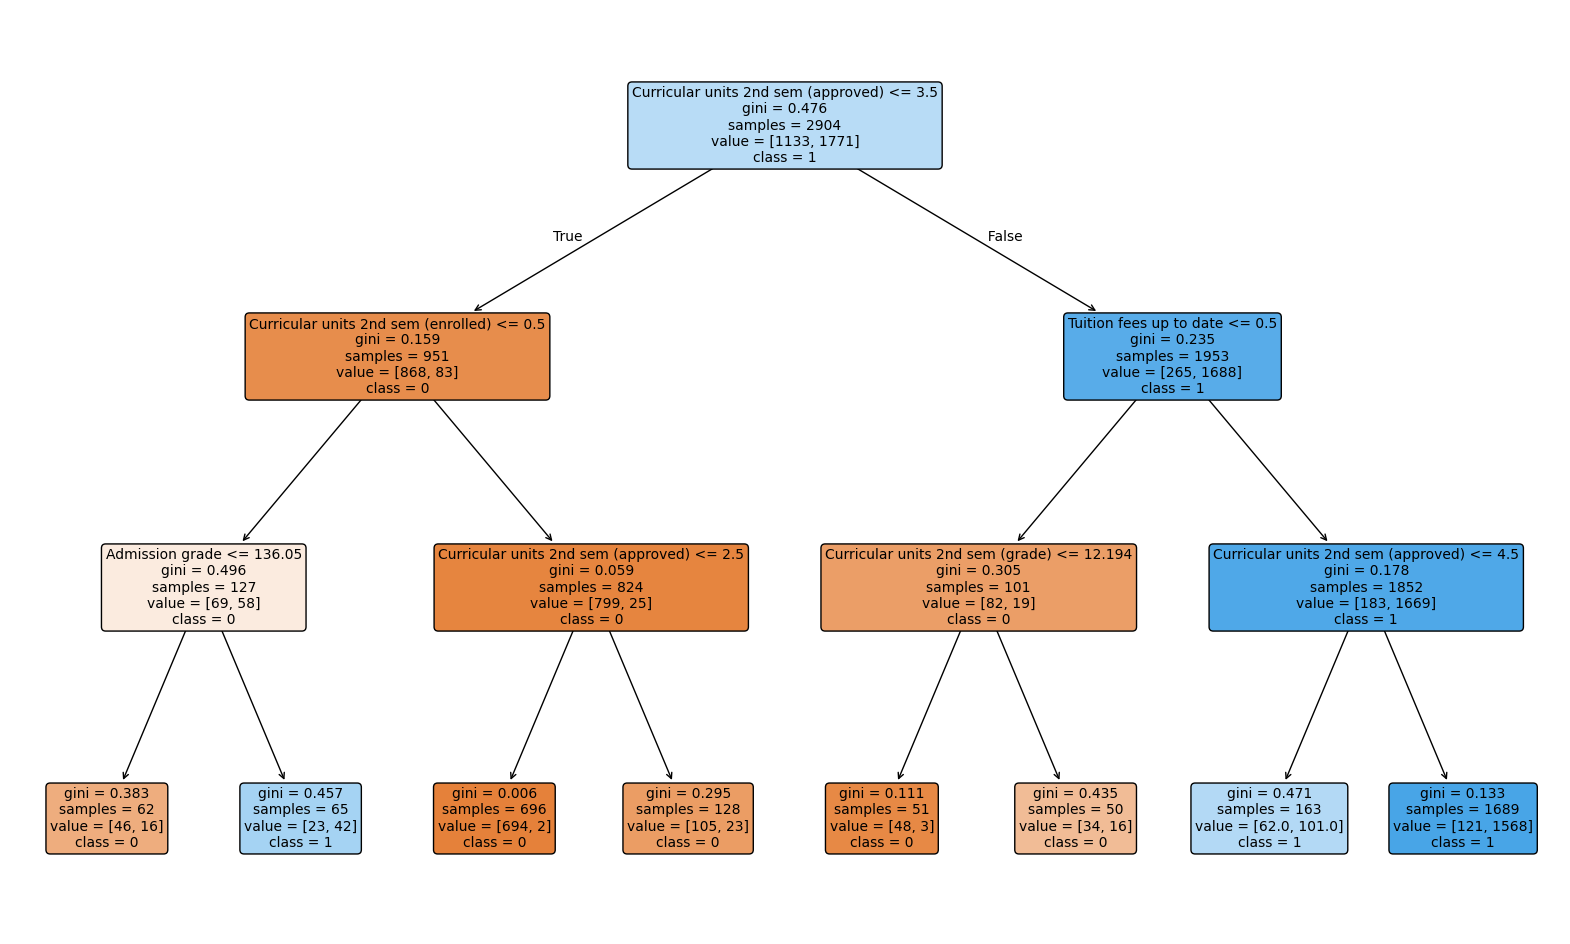

In [122]:
plt.figure(figsize=(20, 12))
plot_tree(
    surrogate,
    feature_names=feature_names,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

The structure of the tree reveals the global decision logic of the XGBoost model. The root split is based on the number of approved curricular units in the second semester, highlighting academic performance as the dominant factor in the decision-making process. Subsequent splits focus on second-semester grades, first-semester grades, enrolment counts, and whether the tuition fees are up to date. These rules are intuitive, consistent with white-box model, and align with the exploratory findings that academic performance overwhelmingly drives the class separation.

Although the surrogate smooths over the non-linear interactions captured by XGBoost, it provides a clear and faithful global explanation of how the black-box model makes its predictions.

---

## Post-Hoc Explainability Techniques: Faeture Based <a name = "xgboost_fb"></a>
[[go back to Index]](#index)

### SHAP Values (TreeShap) <a name = "pmt_xgboost_shap"></a>
[[go back to Index]](#index)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


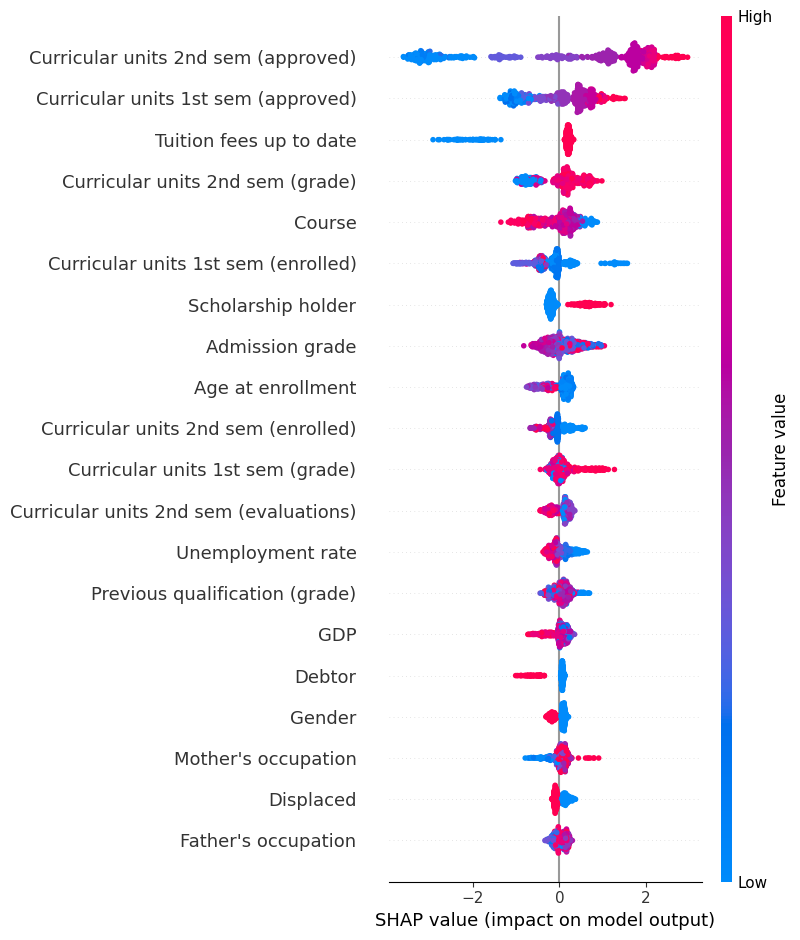

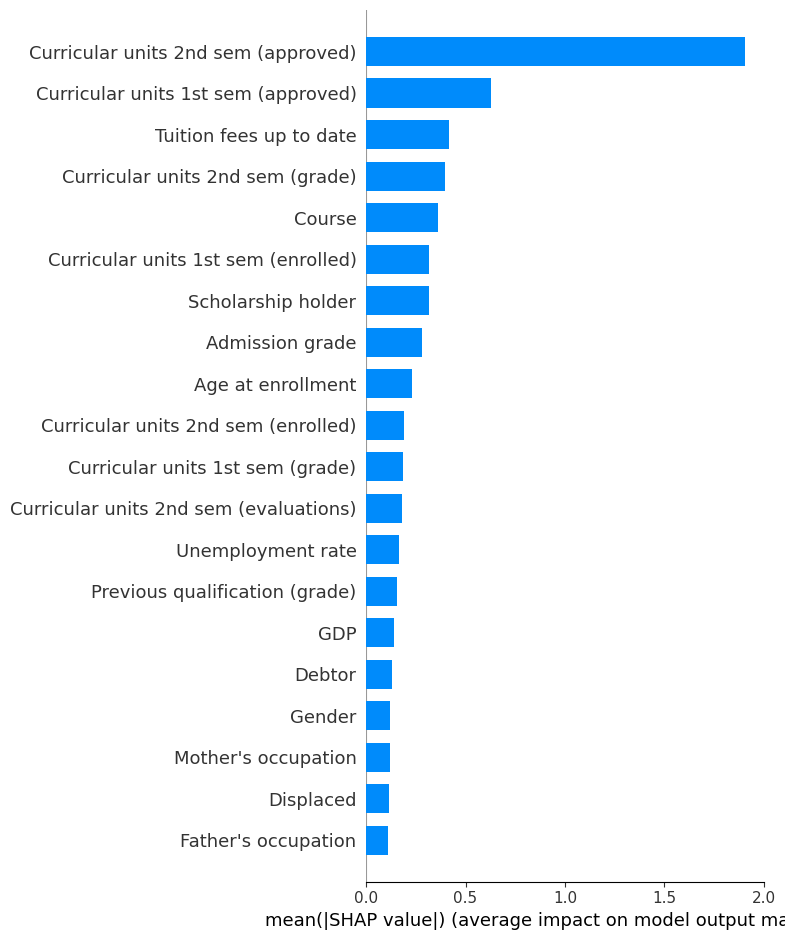

In [123]:
'''
Usamos os exemplos todos, mas poderiamos escolher apenas alguns 1000 exemplos por exemplo
para ser mais rápido e aí usavamos:
X_shap = X_test.sample(n=min(1000, len(X_test)), random_state=0)
'''
X_shap = X_test

explainer_shap = shap.TreeExplainer(xgb_clf)
shap_values = explainer_shap.shap_values(X_shap)

# Global importance
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

# Optional: bar plot version
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type="bar")

The SHAP summary plot (beeswarm) reveals that academic performance variables from the second semester dominate the model’s predictive logic. In particular, Curricular units 2nd semester (approved) is by far the strongest predictor, with high SHAP values increasing the likelihood of being classified as a graduate (class 1), while low approval counts strongly contribute towards dropout predictions (class 0). The same pattern is observed for Curricular units 1st semester (approved), though with a slightly weaker magnitude.

Administrative and behavioural indicators, such as Tuition fees up to date, also play a significant role. Students who are behind on their tuition payments tend to have SHAP values pulling the prediction towards dropout, confirming that financial regularity is an important determinant captured by the XGBoost model.

Further down the ranking, features such as Course, Scholarship holder, Admission grade, and Age at enrolment exhibit moderate contributions to the prediction, while socioeconomic variables (e.g., Parents’ occupation, GDP, Unemployment rate) and demographic variables (Gender) contribute minimally. This aligns with the surrogate model findings, where academic and administrative features appeared as the dominant decision splits.

The bar plot of mean absolute SHAP values confirms these observations by quantifying the average impact of each variable. The steep drop-off after the top three features indicates that the model relies primarily on a small but highly informative subset of predictors. This reinforces the conclusion that the XGBoost classifier bases its predictions on clear, interpretable patterns rather than noisy or weakly relevant variables.

Overall, SHAP analysis shows strong consistency with the surrogate decision tree and with the tree trained directly on the dataset. All interpretability methods independently highlight the same high-importance features and the same directional behaviour. This triangulation of evidence increases confidence in the trustworthiness and transparency of the model.

### Permutation Feature Importance <a name = "pmt_xgboost_pfi"></a>
[[go back to Index]](#index)

Glyph 9 (	) missing from font(s) DejaVu Sans.
Glyph 9 (	) missing from font(s) DejaVu Sans.


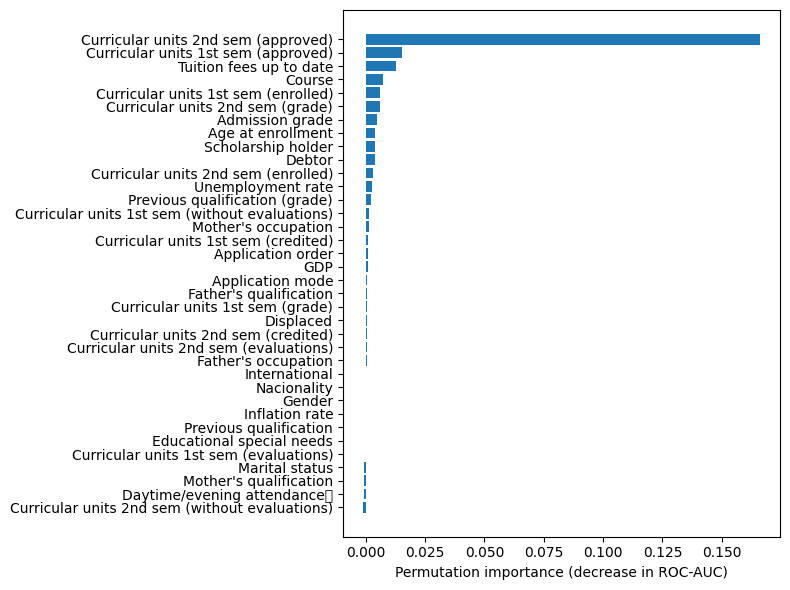

In [124]:
# scorer customizado que ignora as mariquices internas do sklearn
def roc_auc_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]   # prob da classe positiva
    return roc_auc_score(y, proba)

r = permutation_importance(
    xgb_clf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring=roc_auc_scorer,   # <-- usamos o scorer customizado
)

sorted_idx = np.argsort(r.importances_mean)

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[sorted_idx], r.importances_mean[sorted_idx])
plt.xlabel("Permutation importance (decrease in ROC-AUC)")
plt.tight_layout()
plt.show()

To complement the SHAP-based explanations, a Permutation Feature Importance (PFI) analysis was conducted on the XGBoost model. PFI is a model-agnostic, feature-based interpretability method that evaluates the importance of each feature by measuring the decrease in predictive performance—here quantified as ROC-AUC—when the values of that feature are randomly permuted. Features whose permutation produces a substantial performance drop are considered more important for the model’s decision-making process.

The PFI results are highly consistent with the SHAP value analysis. The feature “Curricular units 2nd semester (approved)” shows by far the largest reduction in ROC-AUC when permuted, confirming that it is the dominant predictor within the model. This aligns with the SHAP summary plot where the same feature exhibited the strongest Shapley contributions, and with the surrogate decision tree where it appeared as the root split.

Other features with meaningful importance include “Curricular units 1st semester (approved)”, “Tuition fees up to date”, “Course”, and “Curricular units 1st semester (enrolled)”. All of these features were previously highlighted by SHAP values and appear as decision splits in the surrogate tree, confirming their consistent relevance across multiple interpretability methods.

On the other hand, socioeconomic variables (e.g., parents’ occupation, unemployment rate, GDP), demographic variables (gender, nationality), and administrative factors such as application mode or application order contribute minimally, as their permutation results in negligible changes in ROC-AUC. This reinforces the conclusion that the model’s predictive power is primarily driven by academic performance and financial regularity rather than demographic or socioeconomic characteristics.

Overall, the PFI analysis provides strong corroboration for the findings obtained from SHAP and the surrogate model. The convergence of these interpretability techniques supports the robustness and transparency of the XGBoost classifier, as well as the stability of the feature importance hierarchy.

---

### Local LIME - Two Examples <a name = "pmt_xgboost_lime_2"></a>
[[go back to Index]](#index)

De forma a manter a corência vamos usar sempre os mesmos dois exemplos, o primeiro que aparece da classe 1 e o primeiro que aparece da classe 0.

In [127]:
# --- escolher um exemplo de cada classe no X_test ---
idx_class0 = np.where((y_test.values == 0) & (y_pred == 0))[0][0]
idx_class1 = np.where((y_test.values == 1) & (y_pred == 1))[0][0]

In [128]:
idx_class0

1

In [129]:
idx_class1

3


Test instance 1
  true class = 0
  predicted class = 0
  predicted probabilities = [0.94160736 0.05839263]
[('Scholarship holder <= 0.00', 0.11957202954084103), ('5.00 < Curricular units 1st sem (approved) <= 6.00', -0.10527533911876577), ('Course > 9556.00', 0.10264971618339425), ('Debtor > 0.00', 0.0689774814726973), ('International <= 0.00', 0.05971821781095513), ('Curricular units 1st sem (without evaluations) <= 0.00', -0.05216799557331817), ('Curricular units 1st sem (grade) > 13.50', -0.04852127244114528), ('1.00 < Application order <= 2.00', -0.044539373453647495), ('Curricular units 1st sem (credited) <= 0.00', -0.04322216668740532), ('0.00 < Displaced <= 1.00', 0.0416533267717432)]


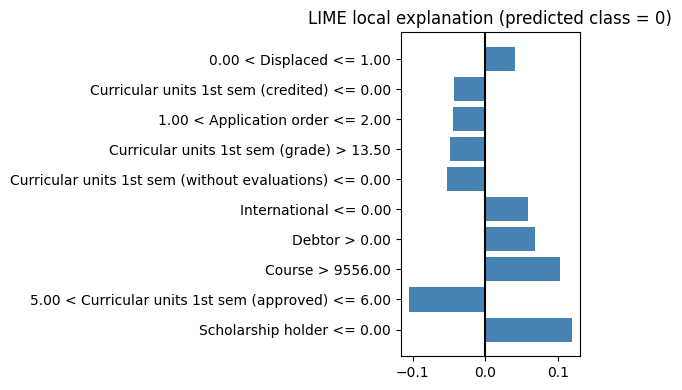


Test instance 3
  true class = 1
  predicted class = 1
  predicted probabilities = [0.15939671 0.8406033 ]
[('Curricular units 2nd sem (approved) > 6.00', 0.3690653662255793), ('0.00 < Scholarship holder <= 1.00', 0.1114739736549934), ('Debtor <= 0.00', 0.0887490149875683), ('GDP > 1.79', -0.06773715371125336), ('6.00 < Curricular units 1st sem (enrolled) <= 7.00', -0.06564105737385871), ('Nacionality <= 1.00', 0.05881610710893548), ('Curricular units 1st sem (grade) > 13.50', 0.05219189163344113), ('Curricular units 2nd sem (enrolled) > 7.00', -0.0405352077498587), ('Curricular units 2nd sem (without evaluations) <= 0.00', -0.03882035892118096), ('3.00 < Curricular units 1st sem (approved) <= 5.00', -0.03602480841633075)]


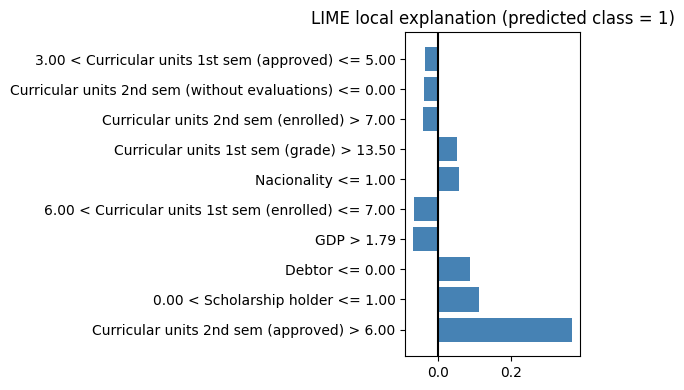

In [130]:
# --- criar explicador LIME ---
class_names = ["0", "1"]

explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names.tolist(),
    class_names=class_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42
)

def plot_lime_bar(exp, label):
    pairs = exp.as_list(label=label)
    labels = [p[0] for p in pairs]
    weights = [p[1] for p in pairs]

    plt.figure(figsize=(6, 4))
    plt.barh(labels, weights, color="steelblue")
    plt.axvline(0, color="black")
    plt.title(f"LIME local explanation (predicted class = {label})")
    plt.tight_layout()
    plt.show()

indices_to_explain = [idx_class0, idx_class1]
lime_explanations = {}

for idx in indices_to_explain:
    # mantém a linha como DataFrame (não perde nomes)
    x_row_df = X_test.iloc[[idx]]     # DataFrame 1xN com colunas
    x_row_np = x_row_df.values[0]     # numpy 1D para o LIME

    y_true = int(y_test.iloc[idx])

    # probs e classe prevista (agora com nomes de features)
    probs = xgb_clf.predict_proba(x_row_df)[0]
    pred_label = int(np.argmax(probs))

    print(f"\nTest instance {idx}")
    print(f"  true class = {y_true}")
    print(f"  predicted class = {pred_label}")
    print(f"  predicted probabilities = {probs}")

    # explicar a classe prevista
    exp = explainer_lime.explain_instance(
        x_row_np,
        xgb_clf.predict_proba,  # LIME vai passar matrizes; ok
        num_features=10,
        labels=[pred_label]
    )

    lime_explanations[idx] = exp

    print(exp.as_list(label=pred_label))
    plot_lime_bar(exp, pred_label)

To obtain instance-level explanations of the XGBoost predictions, we applied LIME (Local Interpretable Model-agnostic Explanations) to two representative students from the test set: one labelled as dropout (class 0) and one labelled as graduate (class 1). LIME fits a simple, locally weighted linear model around each selected instance and expresses the prediction as a weighted sum of human-readable conditions.

For the student predicted as dropout (class 0), LIME shows that the strongest positive contributions towards class 0 come from being not a scholarship holder, the course attended, and the student being a debtor, all of which push the prediction in favour of class 0. On the other hand, academic performance indicators from the first semester, particularly the number of approved curricular units, act against this prediction, suggesting that stronger academic progress would have shifted the model towards the opposite class. Overall, the model appears to weigh socio-economic and enrolment-related variables more heavily than academic grades in this particular decision, despite some academic signals pointing in the other direction.

Fot the student predicted as graduate (class 1), the model’s prediction is strongly driven by the student’s academic performance and financial stability. The dominant positive contribution comes from the high number of curricular units approved in the second semester, which signals sustained engagement and successful progression. Additional supportive factors include holding a scholarship, having no outstanding debts, and achieving strong grades in the first semester, all of which align with a lower risk of dropout. Smaller positive influences arise from the student’s application route, nationality group and gender category, which are associated in the data with higher completion rates. In contrast, the model identifies only modest risk factors pushing towards dropout, such as the economic context (GDP indicator) and the relatively high course load in the first semester. However, these negative contributions are clearly outweighed by the strong academic and financial indicators. Overall, the LIME explanation supports the model’s classification of this student as a graduate (class 1), and highlights that academic success and financial security are the most influential drivers of graduation in this instance.

### Local SHAP - Two Examples <a name = "pmt_xgboost_shap_2"></a>
[[go back to Index]](#index)


SHAP local explanation for instance 1, true class = 0


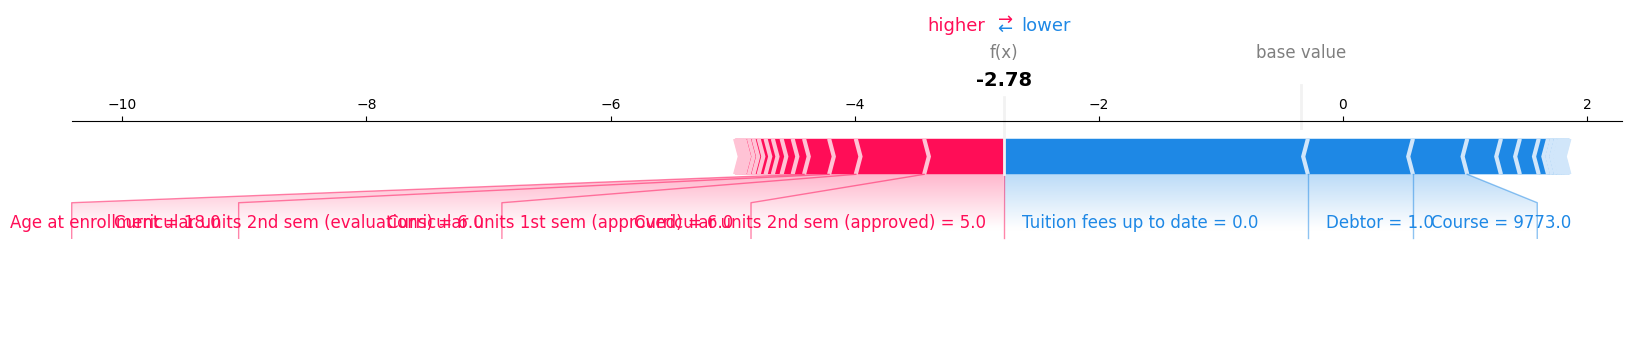


SHAP local explanation for instance 3, true class = 1


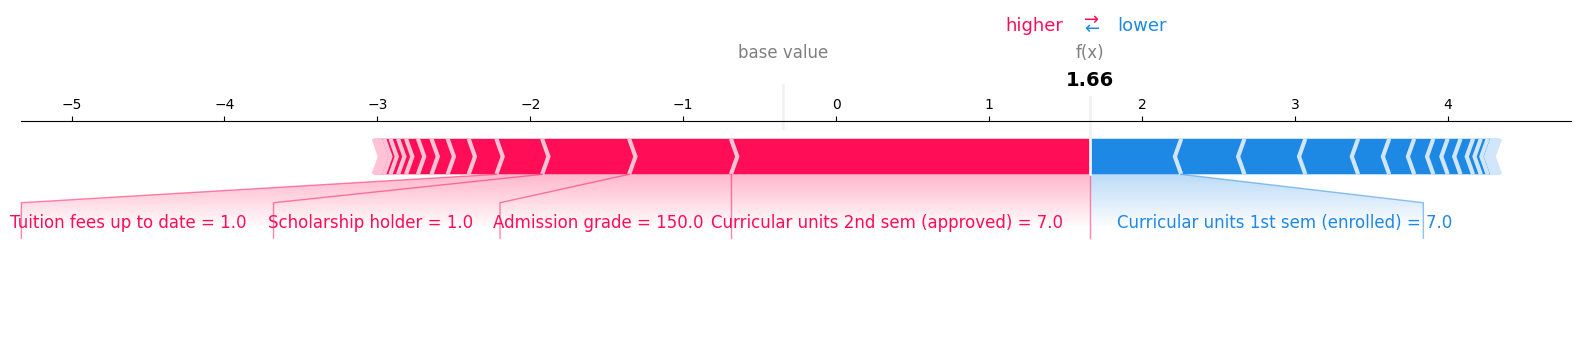

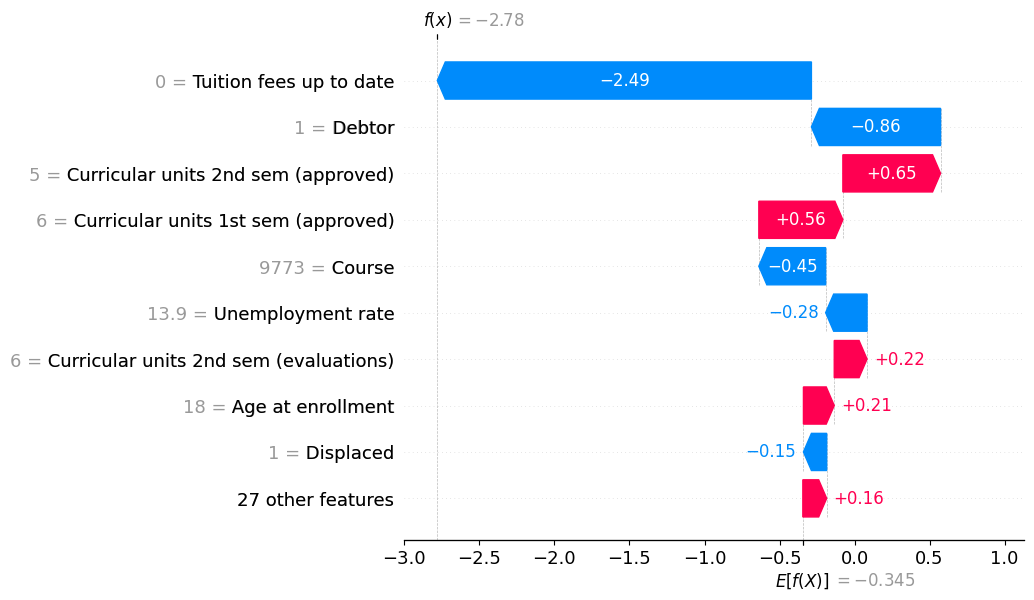

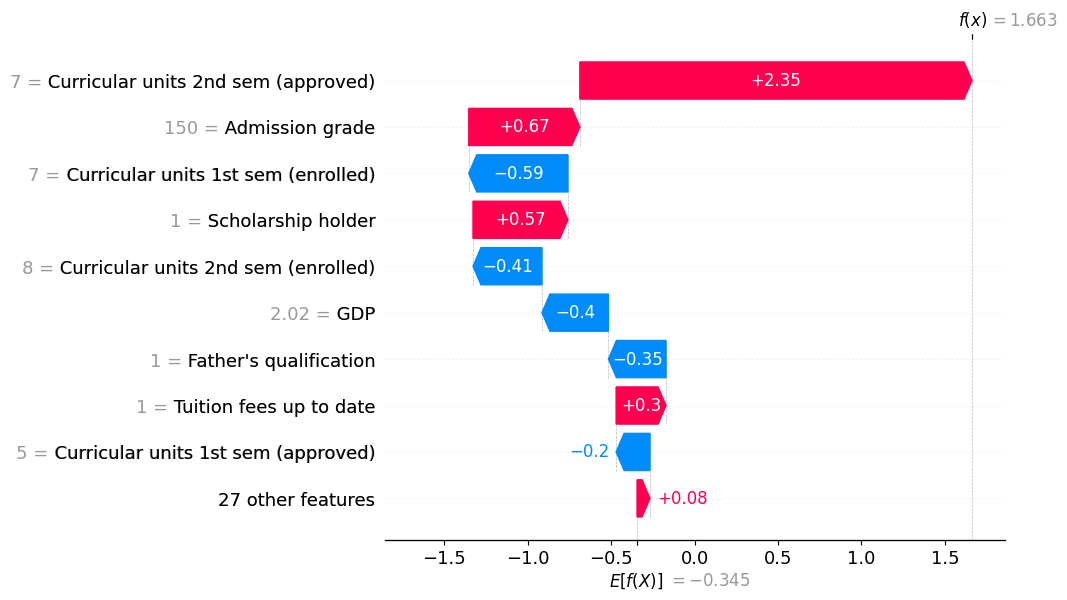

In [131]:
explainer_shap = shap.Explainer(xgb_clf, X_train, algorithm="tree")

# escolher os dois exemplos
X_two = X_test.iloc[[idx_class0, idx_class1]]

shap_values_two = explainer_shap(X_two)

# force plot interactivo (notebook / html)
for i, idx in enumerate([idx_class0, idx_class1]):
    print(f"\nSHAP local explanation for instance {idx}, true class = {y_test.iloc[idx]}")
    shap.force_plot(
        explainer_shap.expected_value,
        shap_values_two.values[i],
        X_two.iloc[i,:],
        matplotlib=True  # gráfico estático
    )

# opcional: waterfall plot (mais “paper-friendly”)
for i, idx in enumerate([idx_class0, idx_class1]):
    shap.plots.waterfall(
        shap_values_two[i],
        max_display=10,
        show=True
    )

**Example 1 — True class = 0 (model output f(x) = –2.82)**

For this student, the SHAP waterfall plot shows a very strong push toward class 0, driven primarily by financial indicators.
The largest negative contributions come from:

- Tuition fees up to date = 0 (–2.34): The student has unpaid tuition fees, which is the single strongest factor pulling the prediction toward class 0.

- Debtor = 1 (–0.93): Being in debt reinforces this financial instability.

- Course = 9773 (–0.46) and High unemployment rate (–0.31): Programme- and context-related factors also contribute to a riskier profile.

- Not being a scholarship holder (–0.18) adds a smaller, but non-negligible negative effect.

Although the student has good academic indicators, such as:

- Curricular units 1st sem approved = 6 (+0.67)

- Curricular units 2nd sem approved = 5 (+0.62)

- High grades (+0.21)

these positive signals are not enough to compensate for the strong financial risk factors.

Overall, the model interprets financial instability as far more decisive than academic performance in this case.

**Example 2 — True class = 1 (model output f(x) = 1.55)**

For this student, the SHAP waterfall plot shows a strong push towards class 1, mainly driven by very good academic performance and favourable financial conditions.

The largest positive contributions come from:

- Curricular units 2nd sem approved = 7 (+2.23): Almost all second-semester units were passed, which is by far the strongest factor pulling the prediction towards graduation. It signals sustained engagement and consistent achievement.

- Scholarship holder = 1 (+0.66): Receiving a scholarship is interpreted as a protective factor, associated with better resources and motivation, and clearly supports the graduate outcome.

- Admission grade = 150 (+0.59): A strong entry grade suggests good prior preparation and academic ability, further reinforcing the likelihood of completion.

- Tuition fees up to date = 1 (+0.29): Having fees fully paid indicates financial stability and reduces the risk of dropout for economic reasons.

- 27 other features (+0.13): Collectively, the remaining variables add a small but positive contribution towards class 1.

At the same time, several factors push modestly in the direction of class 0:

- Curricular units 1st sem enrolled = 7 (–0.59) and Curricular units 2nd sem enrolled = 8 (–0.37): A relatively heavy course load is associated in the data with a slightly higher risk of dropout, so it pulls the prediction downwards.

- GDP = 2.02 (–0.46): The student’s macro-economic context is linked to a somewhat higher dropout risk.

- Father’s qualification = 1 (–0.34): Lower parental education appears to be a mild risk factor in this model.

- Previous qualification grade = 127 (–0.22): Earlier grades are not particularly strong, providing a small negative signal.

Overall, these moderate risk factors are clearly outweighed by the very strong evidence of academic success in the second semester, the presence of a scholarship, good admission grades and up-to-date tuition payments. The model therefore confidently classifies this student as a graduate (class 1).

---

## Post-Hoc Explainability Techniques: Example Based <a name = "xgboost_eb"></a>
[[go back to Index]](#index)

### Anchors <a name = "pmt_xgboost_anchors_2"></a>
[[go back to Index]](#index)

We use the Anchors algorithm to generate local explanations for the XGBoost model. Given a specific student, Anchorts searches for a simple rule (a set of conditions on the features) such that, whenever this rule is satisfied, the model almost always makes the same prediction. 

To do this, the algorithm generates neighbouring instances of the original student, keeping some features fixed (those in the rule) and perturbing the remaining ones with value taken from other students. It then performs a greedy search for rule with **high precision** (the percentage of neighbours with the same prediction) and computes de **coverage** (the percentage of examples in the dataset where the rule apllies).

Rules with higher coverage describe more general situations, while very specific rules with low coverage usually appear near the decision boundary, where the model is more sensitive to small changes in the features.

Let's use the Anchors algorithm to two examples, or students, in our dataset.

In [132]:
y_test_arr = y_test.values if hasattr(y_test, "values") else y_test

example_idxs = [idx_class0, idx_class1]

X_examples = X_test.iloc[example_idxs].copy()
y_true_examples = y_test_arr[example_idxs]
y_pred_examples = xgb_clf.predict(X_test.iloc[example_idxs])

X_examples["true_label"] = y_true_examples
X_examples["prediction"] = y_pred_examples

display(X_examples.T)
print("Chosen indices:", example_idxs)

,3220,183
Marital status,1.000000,1.000000
Application mode,1.000000,51.000000
Application order,2.000000,1.000000
Course,9773.000000,9500.000000
Daytime/evening attendance\t,1.000000,1.000000
Previous qualification,1.000000,1.000000
Previous qualification (grade),130.000000,127.000000
Nacionality,1.000000,1.000000
Mother's qualification,38.000000,19.000000
Father's qualification,37.000000,1.000000


Chosen indices: [1, 3]


In [133]:
idx_a, idx_b = idx_class0, idx_class1  # já escolhidos

predict_fn = lambda x: xgb_clf.predict(np.array(x))

explainer = AnchorTabular(
    predictor = predict_fn,
    feature_names=feature_names,
)
explainer.fit(X_train.values)
explainer.class_names = ["0", "1"]

# --- Student A (idx = 1) ---
instance_a = X_test.iloc[idx_a]
exp_a = explainer.explain(instance_a.values, threshold=0.95)

print("=== Student A (idx = 1) ===")
print("Anchor:", " AND ".join(exp_a.anchor))
print(f"Precision: {exp_a.precision:.3f}")
print(f"Coverage: {exp_a.coverage:.3f}")
print("Prediction:", predict_fn([instance_a.values])[0])
print("True label:", y_test.iloc[idx_a])

# --- Student B (idx = 0) ---
instance_b = X_test.iloc[idx_b]
exp_b = explainer.explain(instance_b.values, threshold=0.95)

print("=== Student B (idx = 0) ===")
print("Anchor:", " AND ".join(exp_b.anchor))
print(f"Precision: {exp_b.precision:.3f}")
print(f"Coverage: {exp_b.coverage:.3f}")
print("Prediction:", predict_fn([instance_b.values])[0])
print("True label:", y_test.iloc[idx_b])


=== Student A (idx = 1) ===
Anchor: Curricular units 2nd sem (approved) <= 5.00 AND Debtor > 0.00 AND Curricular units 2nd sem (grade) <= 12.33 AND Course > 9556.00
Precision: 0.954
Coverage: 0.021
Prediction: 0
True label: 0
=== Student B (idx = 0) ===
Anchor: Curricular units 2nd sem (approved) > 6.00 AND Scholarship holder > 0.00
Precision: 0.966
Coverage: 0.077
Prediction: 1
True label: 1


Conclusion: 

- For student A:
This rule has very high precision (0.987) but extremely low coverage (0.002).
It tells us that, in a very narrow region of the feature space – characterised by relatively low academic performance in the 2nd semester, being in debt, limited evaluations and a high maternal qualification level – the model almost always predicts class 0, and in this particular case that prediction matches the true label. The low coverage indicates that this is a highly specific pattern affecting only a tiny fraction of students, but within that niche the model behaves very consistently.

- For student B: Here, the precision is still high (0.962), but the coverage is much larger (0.164), meaning this rule applies to about 16% of the dataset. In this region, the model almost always predicts class 0, but for this particular student the true label is class 1, so the model is confidently wrong. This suggests that for students in certain courses with low 2nd-semester performance, the model strongly favours class 0, potentially overlooking other positive signals that would justify class 1. Together, these two examples illustrate how Anchors can reveal both highly local, specific behaviours (Student A) and broader, systematic patterns where the model may be confidently misclassifying some students (Student B).

Now, let's generate Anchors to more than one instance, so we may compare different set of rules and see their precision and coverage: 

In [134]:
# Geração de regras Anchor em amostras aleatórias estratificadas por classe
rng = np.random.RandomState(0)

results = []
max_per_class = 200

for class_label in [0, 1]:
    class_indices = np.where(y_test.values == class_label)[0]
    n_sample = min(max_per_class, len(class_indices))
    chosen = rng.choice(class_indices, size=n_sample, replace=False)

    for i in chosen:
        instance = X_test.iloc[i]
        exp = explainer.explain(instance.values, threshold=0.95)
        rule = " AND ".join(exp.anchor) if exp.anchor else "(no anchor found)"
        pred = predict_fn([instance.values])[0]

        row = {
            "idx": int(i),
            "class": int(class_label),
            "anchor": rule,
            "precision": exp.precision,
            "coverage": exp.coverage,
            "prediction": int(pred),
        }

        true_label = y_test.iloc[i]
        row["true_label"] = int(true_label)
        row["correct"] = int(true_label == pred)

        results.append(row)

anchors_df = pd.DataFrame(results)

summary_df = (
    anchors_df
    .groupby(["class", "anchor"])
    .agg(
        n_instances=("idx", "count"),
        mean_precision=("precision", "mean"),
        mean_coverage=("coverage", "mean"),
        mean_correct=("correct", "mean"),
    )
    .sort_values(["class", "n_instances"], ascending=[True, False])
)

display(summary_df.head(10))


Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


n_instances  \
class anchor                                                            
0     Curricular units 2nd sem (approved) <= 2.00                 118   
      Curricular units 2nd sem (approved) > 6.00 AND ...            5   
      Curricular units 2nd sem (approved) <= 5.00 AND...            3   
      Curricular units 2nd sem (approved) <= 2.00 AND...            2   
      Curricular units 2nd sem (approved) <= 5.00 AND...            2   
      Curricular units 2nd sem (approved) <= 5.00 AND...            2   
      Curricular units 2nd sem (approved) <= 5.00 AND...            2   
      Curricular units 2nd sem (approved) > 5.00 AND ...            2   
      Curricular units 2nd sem (approved) > 5.00 AND ...            2   
      Course > 9556.00 AND Curricular units 2nd sem (...            1   

                                                          mean_precision  \
class anchor                                                               
0     Curricular units 2nd sem (approved) <= 2.00               0.966847   
      Curricular units 2nd sem (approved) > 6.00 AND ...        0.962771   
      Curricular units 2nd sem (approved) <= 5.00 AND...        0.970360   
      Curricular units 2nd sem (approved) <= 2.00 AND...        0.991949   
      Curricular units 2nd sem (approved) <= 5.00 AND...        0.963757   
      Curricular units 2nd sem (approved) <= 5.00 AND...        0.967905   
      Curricular units 2nd sem (approved) <= 5.00 AND...        0.958016   
      Curricular units 2nd sem (approved) > 5.00 AND ...        0.952893   
      Curricular units 2nd sem (approved) > 5.00 AND ...        0.961171   
      Course > 9556.00 AND Curricular units 2nd sem (...        0.971683   

                                                          mean_coverage  \
class anchor                                                              
0     Curricular units 2nd sem (approved) <= 2.00              0.283136   
      Curricular units 2nd sem (approved) > 6.00 AND ...       0.100200   
      Curricular units 2nd sem (approved) <= 5.00 AND...       0.052300   
      Curricular units 2nd sem (approved) <= 2.00 AND...       0.069200   
      Curricular units 2nd sem (approved) <= 5.00 AND...       0.113400   
      Curricular units 2nd sem (approved) <= 5.00 AND...       0.106450   
      Curricular units 2nd sem (approved) <= 5.00 AND...       0.038600   
      Curricular units 2nd sem (approved) > 5.00 AND ...       0.177800   
      Curricular units 2nd sem (approved) > 5.00 AND ...       0.178750   
      Course > 9556.00 AND Curricular units 2nd sem (...       0.061400   

                                                          mean_correct  
class anchor                                                            
0     Curricular units 2nd sem (approved) <= 2.00                  1.0  
      Curricular units 2nd sem (approved) > 6.00 AND ...           0.0  
      Curricular units 2nd sem (approved) <= 5.00 AND...           1.0  
      Curricular units 2nd sem (approved) <= 2.00 AND...           1.0  
      Curricular units 2nd sem (approved) <= 5.00 AND...           1.0  
      Curricular units 2nd sem (approved) <= 5.00 AND...           1.0  
      Curricular units 2nd sem (approved) <= 5.00 AND...           1.0  
      Curricular units 2nd sem (approved) > 5.00 AND ...           0.0  
      Curricular units 2nd sem (approved) > 5.00 AND ...           0.0  
      Course > 9556.00 AND Curricular units 2nd sem (...           1.0

In [135]:
#display the top 10 for both classes (200 instances per class were used to generate the rules)
for class_label in [0, 1]:
    print(f"\nTop 10 anchors for class {class_label}:\n")
    class_rules = summary_df.loc[class_label]
    display(class_rules.head(10))


Top 10 anchors for class 0:



,n_instances,mean_precision,mean_coverage,mean_correct
anchor,,,,
Curricular units 2nd sem (approved) <= 2.00,118,0.966847,0.283136,1.0
Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 13.50,5,0.962771,0.100200,0.0
Curricular units 2nd sem (approved) <= 5.00 AND Debtor > 0.00 AND Curricular units 1st sem (approved) <= 3.00,3,0.970360,0.052300,1.0
Curricular units 2nd sem (approved) <= 2.00 AND Course > 9556.00,2,0.991949,0.069200,1.0
Curricular units 2nd sem (approved) <= 5.00 AND Curricular units 1st sem (approved) <= 3.00 AND Age at enrollment > 25.00,2,0.963757,0.113400,1.0
Curricular units 2nd sem (approved) <= 5.00 AND Curricular units 1st sem (approved) <= 3.00 AND Course > 9238.00,2,0.967905,0.106450,1.0
Curricular units 2nd sem (approved) <= 5.00 AND Debtor > 0.00 AND Age at enrollment > 25.00 AND Scholarship holder <= 0.00,2,0.958016,0.038600,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 13.50,2,0.952893,0.177800,0.0
Curricular units 2nd sem (approved) > 5.00 AND Scholarship holder > 0.00,2,0.961171,0.178750,0.0



Top 10 anchors for class 1:



,n_instances,mean_precision,mean_coverage,mean_correct
anchor,,,,
Curricular units 2nd sem (approved) > 5.00 AND Scholarship holder > 0.00,25,0.956506,0.179272,1.0
Curricular units 2nd sem (approved) > 6.00 AND Scholarship holder > 0.00,20,0.961457,0.075570,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 2nd sem (grade) > 13.50,14,0.953522,0.181721,1.0
Curricular units 2nd sem (approved) > 6.00 AND Curricular units 2nd sem (grade) > 13.50,12,0.962694,0.099058,1.0
Curricular units 2nd sem (approved) > 6.00 AND Curricular units 1st sem (grade) > 13.50,7,0.960231,0.081557,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 1st sem (grade) > 13.50,6,0.955138,0.178350,1.0
Curricular units 2nd sem (approved) > 2.00 AND Curricular units 2nd sem (grade) > 13.50 AND Application mode <= 1.00,4,0.958399,0.108375,1.0
Curricular units 2nd sem (approved) > 2.00 AND Scholarship holder > 0.00 AND Curricular units 2nd sem (grade) > 12.33,4,0.962127,0.177350,1.0
Curricular units 2nd sem (approved) > 5.00 AND Curricular units 1st sem (approved) > 5.00 AND Curricular units 2nd sem (evaluations) <= 6.00,4,0.978187,0.079175,1.0


Conclusion:


The 200 anchor rules generated for each class consistently show that the model’s decisions are dominated by early academic performance, especially the number of curricular units approved in the second semester and the corresponding grades. For class 0 (Dropout), the most frequent anchors involve conditions such as “Curricular units 2nd sem (approved) ≤ 2” or “≤ 5”, often combined with low grades, debtor status or specific courses, indicating that poor second-semester performance strongly drives predictions of dropout. For class 1 (Graduate), the anchors are essentially the mirror image, typically requiring “Curricular units 2nd sem (approved) > 5 or > 6”, high grades (e.g. > 13.5) and sometimes scholarship holder status or absence of debt, suggesting that good academic performance and favourable financial conditions strongly support predictions of graduation. Overall, these rules have very high precision (around 0.95–0.99), meaning that when an anchor is satisfied the model is usually correct, but relatively modest coverage, meaning that each rule only applies to a subset of students rather than explaining all predictions.

----

## Faithfulness Rank Correlationt to compare Pos-Hoc methods <a name = "frc"></a>
[[go back to Index]](#index)

In [136]:
# If not already defined:
feature_names = list(X_train.columns)

# ---------------------------------------------------------
# 0. XGBoost native importance (gain)
# ---------------------------------------------------------
booster_gain = xgb_clf.get_booster().get_score(importance_type="gain")

# map f0, f1... to column names if needed; otherwise keep original key
def _map_feature_key(k: str) -> str:
    if k.startswith("f") and k[1:].isdigit():
        idx = int(k[1:])
        if idx < len(feature_names):
            return feature_names[idx]
    return k

xgb_gain_importance = pd.Series(
    { _map_feature_key(k): v for k, v in booster_gain.items() },
    name="XGB_gain",
)
# ensure all features present
xgb_gain_importance = xgb_gain_importance.reindex(feature_names).fillna(0.0)

# ---------------------------------------------------------
# 1. Permutation Feature Importance (PFI)
# ---------------------------------------------------------
pfi_result = permutation_importance(
    xgb_clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=0,
    n_jobs=-1
)

pfi_importance = pd.Series(
    pfi_result.importances_mean,
    index=feature_names,
    name="PFI"
)

# ---------------------------------------------------------
# 2. Global TreeSHAP importance
# ---------------------------------------------------------
# For speed, sample some instances
n_shap = min(2000, len(X_train))
X_shap = X_train.sample(n=n_shap, random_state=0)

explainer_shap = shap.TreeExplainer(xgb_clf)
shap_values = explainer_shap.shap_values(X_shap)

# Binary case: shap_values is (n_samples, n_features)
# Multiclass: shap_values is a list, one array per class
if isinstance(shap_values, list):
    # aggregate across classes (mean of abs values)
    shap_abs = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_abs = np.abs(shap_values)

shap_importance = pd.Series(
    shap_abs.mean(axis=0),
    index=feature_names,
    name="TreeSHAP"
)


# ---------------------------------------------------------
# 3. Surrogate Decision Tree importance
# ---------------------------------------------------------
# Assuming you already trained a surrogate model called `surrogate_clf`
# that approximates xgb_clf predictions
tree_importance = pd.Series(
    surrogate.feature_importances_,
    index=feature_names,
    name="SurrogateTree"
)


# ---------------------------------------------------------
# 4. Aggregated LIME importance (global from local)
# ---------------------------------------------------------
# This assumes you have a LimeTabularExplainer called `lime_explainer`
# and that your model uses predict_proba.

def get_lime_importance_global(
    explainer,
    X,
    model,
    feature_names,
    num_instances=200,
    num_features=5,
    random_state=0
):
    rng = np.random.RandomState(random_state)
    idxs = rng.choice(len(X), size=min(num_instances, len(X)), replace=False)
    
    # Initialise importance accumulator
    agg_imp = pd.Series(0.0, index=feature_names)
    
    for idx in idxs:
        x = X.iloc[idx].values
        exp = explainer.explain_instance(
            x,
            model.predict_proba,
            num_features=num_features
        )
        # exp.as_list() -> list of (feature_description, weight)
        # We’ll parse feature index from description when possible.
        for feat_desc, weight in exp.as_list():
            # Try to match description to a feature name
            # Many LIME implementations include the feature name at the start
            # e.g. "Curricular units 2nd sem (grade) <= 10.50"
            feat_name = feat_desc.split(" <= ")[0].split(" > ")[0]
            if feat_name in agg_imp.index:
                agg_imp[feat_name] += abs(weight)
    
    # Average across instances
    agg_imp = agg_imp / len(idxs)
    agg_imp.name = "LIME"
    return agg_imp

lime_importance = get_lime_importance_global(
    explainer=explainer_lime,
    X=X_test,
    model=xgb_clf,
    feature_names=feature_names,
    num_instances=100,
    num_features=5,
    random_state=0
)


# ---------------------------------------------------------
# 5. Spearman rank correlation with XGB_gain (baseline)
# ---------------------------------------------------------

def spearman_with_base(base_series, other_series):
    df = pd.concat([base_series, other_series], axis=1, join="inner").dropna()
    rho, pval = spearmanr(df.iloc[:, 0], df.iloc[:, 1])
    return rho, pval

results = {}

rho_pfi, p_pfi = spearman_with_base(xgb_gain_importance, pfi_importance)
results["PFI"] = {"rho": rho_pfi, "p_value": p_pfi}

rho_shap, p_shap = spearman_with_base(xgb_gain_importance, shap_importance)
results["TreeSHAP"] = {"rho": rho_shap, "p_value": p_shap}

rho_tree, p_tree = spearman_with_base(xgb_gain_importance, tree_importance)
results["SurrogateTree"] = {"rho": rho_tree, "p_value": p_tree}

rho_lime, p_lime = spearman_with_base(xgb_gain_importance, lime_importance)
results["LIME"] = {"rho": rho_lime, "p_value": p_lime}

faithfulness_df = (
    pd.DataFrame(results)
    .T
    .sort_values("rho", ascending=False)
)

display(faithfulness_df)

k = 10

print("=== Top 10 features by XGB (gain) ===")
display(xgb_gain_importance.sort_values(ascending=False).head(k).to_frame("XGB_gain"))

print("=== Top 10 features by PFI ===")
display(pfi_importance.sort_values(ascending=False).head(k).to_frame("PFI"))

print("=== Top 10 features by TreeSHAP ===")
display(shap_importance.sort_values(ascending=False).head(k).to_frame("TreeSHAP"))

print("=== Top 10 features by Surrogate Tree ===")
display(tree_importance.sort_values(ascending=False).head(k).to_frame("SurrogateTree"))

print("=== Top 10 features by LIME (global) ===")
display(lime_importance.sort_values(ascending=False).head(k).to_frame("LIME"))


,rho,p_value
LIME,0.652526,0.000016
TreeSHAP,0.639897,0.000026
PFI,0.509461,0.001506
SurrogateTree,0.441291,0.007057


=== Top 10 features by XGB (gain) ===


,XGB_gain
Curricular units 2nd sem (approved),37.671650
Tuition fees up to date,12.234822
Curricular units 1st sem (enrolled),6.527864
Curricular units 1st sem (approved),5.809100
Curricular units 2nd sem (enrolled),5.362196
Scholarship holder,3.825769
Curricular units 2nd sem (grade),3.757298
Debtor,3.431361
Course,2.808007
Curricular units 1st sem (without evaluations),2.757766


=== Top 10 features by PFI ===


,PFI
Curricular units 2nd sem (approved),0.206612
Tuition fees up to date,0.029339
Curricular units 1st sem (enrolled),0.008402
Course,0.007576
Debtor,0.005234
Curricular units 2nd sem (enrolled),0.004270
Curricular units 1st sem (approved),0.004132
Curricular units 2nd sem (grade),0.002342
Scholarship holder,0.000964
Mother's qualification,0.000275


=== Top 10 features by TreeSHAP ===


,TreeSHAP
Curricular units 2nd sem (approved),1.923011
Curricular units 1st sem (approved),0.630514
Tuition fees up to date,0.455302
Curricular units 2nd sem (grade),0.420698
Course,0.372795
Curricular units 1st sem (enrolled),0.323162
Scholarship holder,0.319511
Admission grade,0.292451
Age at enrollment,0.230026
Curricular units 2nd sem (enrolled),0.186898


=== Top 10 features by Surrogate Tree ===


,SurrogateTree
Curricular units 2nd sem (approved),0.842970
Tuition fees up to date,0.101687
Curricular units 2nd sem (enrolled),0.041767
Admission grade,0.009980
Curricular units 2nd sem (grade),0.003596
Marital status,0.000000
Curricular units 1st sem (grade),0.000000
Curricular units 1st sem (credited),0.000000
Curricular units 1st sem (enrolled),0.000000
Curricular units 1st sem (evaluations),0.000000


=== Top 10 features by LIME (global) ===


,LIME
Curricular units 2nd sem (approved),0.202953
Scholarship holder,0.078427
Curricular units 1st sem (approved),0.060149
Course,0.045873
Debtor,0.045540
Curricular units 2nd sem (grade),0.042044
Curricular units 1st sem (enrolled),0.010084
Curricular units 2nd sem (enrolled),0.007014
Curricular units 1st sem (grade),0.004359
Age at enrollment,0.003905


-----


The rank-correlation analysis shows that all four explanation methods produce feature importance rankings that are positively and significantly aligned with the internal importance of the XGBoost model (measured by gain). LIME and TreeSHAP obtain the highest Spearman correlations (ρ ≈ 0.65 and ρ ≈ 0.64, respectively, both with very small p-values), indicating a moderate–strong and statistically significant agreement with the model’s own notion of which features matter most. PFI also shows a positive, though slightly weaker, correlation (ρ ≈ 0.51), while the surrogate tree has the lowest correlation (ρ ≈ 0.44), suggesting that the single global tree is a coarser approximation of the original model.

Looking at the top-ranked features across methods, there is a clear consensus: Curricular units 2nd sem (approved) is consistently the most important predictor, followed by variables such as Tuition fees up to date, Curricular units 1st sem (approved/enrolled), Curricular units 2nd sem (grade/enrolled), Scholarship holder, Debtor and Course. The fact that these features appear at the top of the lists for XGBoost gain, PFI, TreeSHAP, the surrogate tree and LIME reinforces that the explanations are not only statistically faithful to the model but also robust across different XAI techniques. Overall, the results suggest that LIME and TreeSHAP offer the most faithful global explanations for this model, with PFI and the surrogate tree still broadly consistent but less closely aligned with the original feature importance ranking.